In [1]:
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import  image_dataset_from_directory
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random

In [2]:
def clone_and_prepare_dataset(github_repo='https://github.com/laxmimerit/dog-cat-full-dataset.git'):
    # Remove existing dataset directory if it exists
    if os.path.exists('dog-cat-full-dataset'):
        print("Removing existing directory 'dog-cat-full-dataset'...")
        shutil.rmtree('dog-cat-full-dataset')

    # Remove existing class directories if they exist
    for subset in ['train', 'validation', 'test']:
        if os.path.exists(subset):
            print(f"Removing existing '{subset}' directory...")
            shutil.rmtree(subset)

    print("Cloning the repository...")
    !git clone {github_repo}

    base_dir = 'dog-cat-full-dataset/data'
    print(f"Checking contents of base directory: {base_dir}")

    if os.path.exists(base_dir):
        print("Files in base directory:")
        print(os.listdir(base_dir))
    else:
        print(f"Directory {base_dir} does not exist.")
        return

    # Create target directories
    os.makedirs('train/cats', exist_ok=True)
    os.makedirs('train/dogs', exist_ok=True)
    os.makedirs('validation/cats', exist_ok=True)
    os.makedirs('validation/dogs', exist_ok=True)
    os.makedirs('test/cats', exist_ok=True)
    os.makedirs('test/dogs', exist_ok=True)

    cat_images = []
    dog_images = []

    for label in ['train', 'test']:
        for subdir in ['cats', 'dogs']:
            image_dir = os.path.join(base_dir, label, subdir)
            if os.path.exists(image_dir):
                images = os.listdir(image_dir)
                for img in images:
                    if subdir == 'cats':
                        cat_images.append(os.path.join(image_dir, img))
                    elif subdir == 'dogs':
                        dog_images.append(os.path.join(image_dir, img))

    print(f"Found {len(cat_images)} cat images and {len(dog_images)} dog images.")

    # Shuffle the lists to ensure randomness
    random.shuffle(cat_images)
    random.shuffle(dog_images)

    # Move images to train, validation, and test sets
    for i, img in enumerate(cat_images):
        if i < 1000:
            shutil.move(img, os.path.join('train/cats', os.path.basename(img)))
        elif i < 1500:  # Next 500 for validation
            shutil.move(img, os.path.join('validation/cats', os.path.basename(img)))
        elif i < 2000:  # Next 500 for test
            shutil.move(img, os.path.join('test/cats', os.path.basename(img)))

    for i, img in enumerate(dog_images):
        if i < 1000:
            shutil.move(img, os.path.join('train/dogs', os.path.basename(img)))
        elif i < 1500:  # Next 500 for validation
            shutil.move(img, os.path.join('validation/dogs', os.path.basename(img)))
        elif i < 2000:  # Next 500 for test
            shutil.move(img, os.path.join('test/dogs', os.path.basename(img)))

    print('Dataset cloned and organized into train, validation, and test sets!')

# Call the function to clone and prepare the dataset
clone_and_prepare_dataset()

Removing existing directory 'dog-cat-full-dataset'...
Removing existing 'train' directory...
Removing existing 'validation' directory...
Removing existing 'test' directory...
Cloning the repository...
Cloning into 'dog-cat-full-dataset'...
remote: Enumerating objects: 25033, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 25033 (delta 0), reused 4 (delta 0), pack-reused 25027 (from 1)
Receiving objects: 100% (25033/25033), 541.85 MiB | 23.62 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (24990/24990), done.
Checking contents of base directory: dog-cat-full-dataset/data
Files in base directory:
['test', 'train']
Found 12500 cat images and 12489 dog images.
Dataset cloned and organized into train, validation, and test sets!


In [3]:
def count_images_in_directories(base_path='/content'):
    directory_structure = {
        'train': {'cats': 0, 'dogs': 0},
        'validation': {'cats': 0, 'dogs': 0},
        'test': {'cats': 0, 'dogs': 0},
    }

    for set_type in directory_structure.keys():
        for class_type in directory_structure[set_type].keys():
            dir_path = os.path.join(base_path, set_type, class_type)
            if os.path.exists(dir_path):
                directory_structure[set_type][class_type] = len([f for f in os.listdir(dir_path) if f.endswith(('jpg', 'jpeg', 'png'))])
            else:
                print(f"Directory {dir_path} does not exist.")

    return directory_structure

def print_image_counts(image_counts):
    print("Image counts in each directory:")
    for set_type, classes in image_counts.items():
        print(f"\n{set_type.capitalize()} Set:")
        for class_type, count in classes.items():
            print(f"  {class_type.capitalize()}: {count} images")

image_counts = count_images_in_directories(base_path='/content')
print_image_counts(image_counts)

Image counts in each directory:

Train Set:
  Cats: 1000 images
  Dogs: 1000 images

Validation Set:
  Cats: 500 images
  Dogs: 500 images

Test Set:
  Cats: 500 images
  Dogs: 500 images


VGG-16 model

In [4]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [5]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Basic feature extraction

In [6]:
base_dir = '/content/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━

In [9]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(4, 4, 512)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,097,665 (8.00 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6471 - loss: 0.6328 - val_accuracy: 0.8240 - val_loss: 0.4383
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8031 - loss: 0.4386 - val_accuracy: 0.8400 - val_loss: 0.3737
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8318 - loss: 0.3784 - val_accuracy: 0.8470 - val_loss: 0.3483
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8620 - loss: 0.3304 - val_accuracy: 0.8510 - val_loss: 0.3228
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8780 - loss: 0.3001 - val_accuracy: 0.8590 - val_loss: 0.3107
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8807 - loss: 0.2916 - val_accuracy: 0.8510 - val_loss: 0.3158
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8805 - loss: 0.2766 - val_accuracy: 0.8650 - val_loss: 0.2918
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9076 - loss: 0.2495 - val_accuracy: 0.

In [13]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('test_loss:', test_loss)
print('test_acc:', test_acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8856 - loss: 0.2974
test_loss: 0.26054537296295166
test_acc: 0.8980000019073486


In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

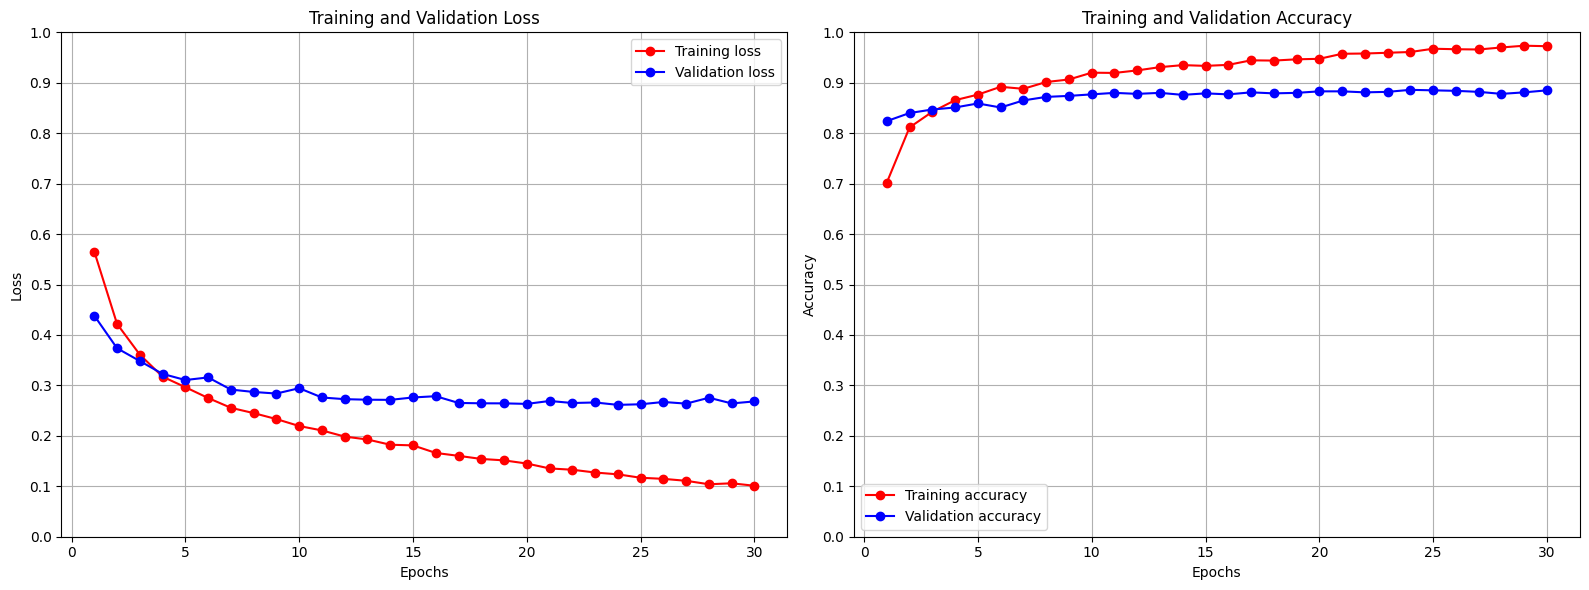

In [15]:
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()

Pre-trained part as an extended layer

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [18]:
conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [19]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      #steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      #validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 21s - 207ms/step - acc: 0.6905 - loss: 0.5991 - val_acc: 0.8270 - val_loss: 0.4419
Epoch 2/30
100/100 - 18s - 182ms/step - acc: 0.7930 - loss: 0.4709 - val_acc: 0.8400 - val_loss: 0.3702
Epoch 3/30
100/100 - 21s - 212ms/step - acc: 0.8000 - loss: 0.4315 - val_acc: 0.8600 - val_loss: 0.3448
Epoch 4/30
100/100 - 20s - 196ms/step - acc: 0.8120 - loss: 0.4129 - val_acc: 0.8670 - val_loss: 0.3236
Epoch 5/30
100/100 - 21s - 208ms/step - acc: 0.8315 - loss: 0.3860 - val_acc: 0.8650 - val_loss: 0.3182
Epoch 6/30
100/100 - 17s - 171ms/step - acc: 0.8290 - loss: 0.3841 - val_acc: 0.8760 - val_loss: 0.2992
Epoch 7/30
100/100 - 20s - 204ms/step - acc: 0.8445 - loss: 0.3543 - val_acc: 0.8810 - val_loss: 0.2914
Epoch 8/30
100/100 - 17s - 173ms/step - acc: 0.8465 - loss: 0.3588 - val_acc: 0.8870 - val_loss: 0.2874
Epoch 9/30
100/100 - 18s - 175ms/step - acc: 0.8595 - loss: 0.3361 - val_acc: 0.8790 - val_loss: 0.2849
Epoch 10/30
100/100 - 20s - 199ms/step - acc: 0.8485 - loss: 0.3509 - val_a

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

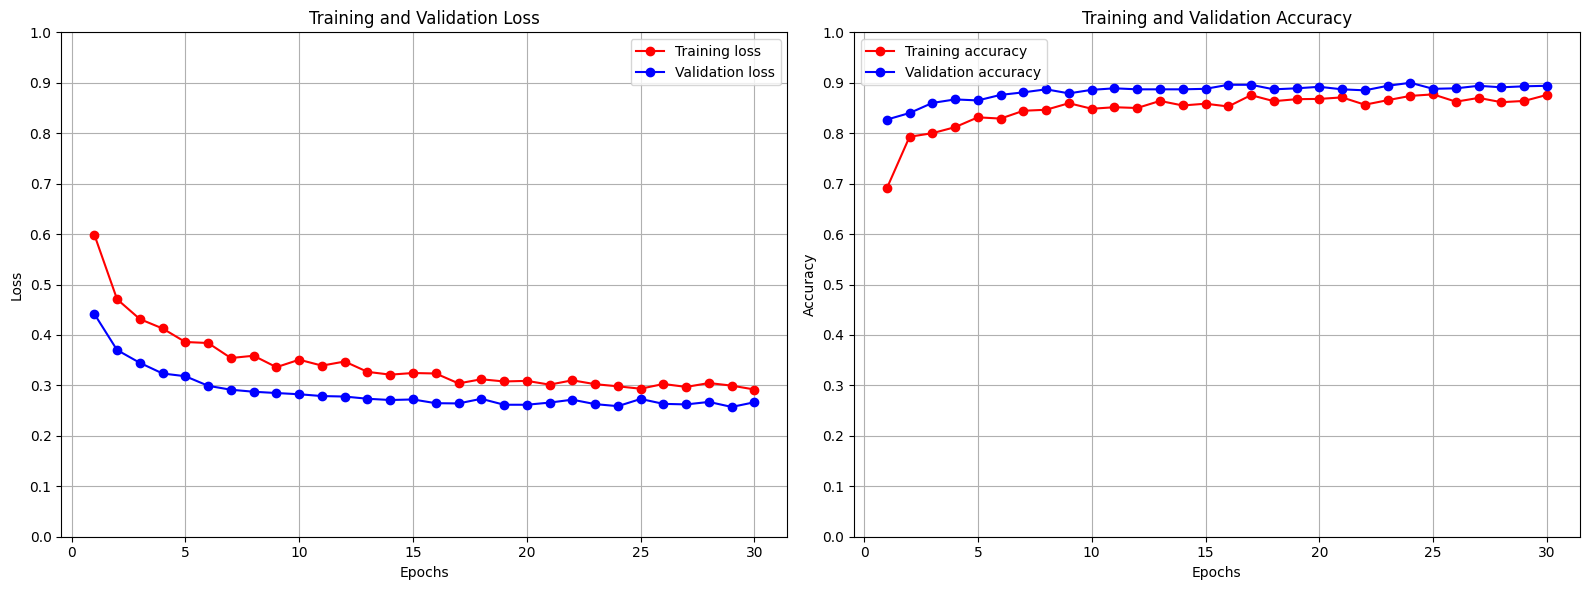

In [21]:
epochs = range(1, len(history_dict['acc']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['acc'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_acc'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()

Fine tuning

In [22]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if (layer.name == 'block5_conv1') or (layer.name == 'block5_conv2') or (layer.name == 'block5_conv3'):
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

In [25]:
history = model.fit(
      train_generator,
      #steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      #validation_steps=50
      )

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 184ms/step - acc: 0.8620 - loss: 0.3211 - val_acc: 0.8960 - val_loss: 0.2752
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - acc: 0.8939 - loss: 0.2497 - val_acc: 0.9010 - val_loss: 0.2358
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - acc: 0.9185 - loss: 0.2036 - val_acc: 0.8990 - val_loss: 0.2635
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - acc: 0.9040 - loss: 0.2156 - val_acc: 0.9080 - val_loss: 0.2315
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - acc: 0.9000 - loss: 0.2028 - val_acc: 0.9080 - val_loss: 0.2145
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - acc: 0.9112 - loss: 0.1905 - val_acc: 0.9130 - val_loss: 0.2034
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - acc: 0.9300 - loss: 0.1582 - val_acc: 0.9180 - val_loss: 0.2130
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - acc: 0.9183 - loss: 0.1922 - val_acc: 0.9140 - val_loss: 0.2083
Epoch 9/100
100/100 ━━━━

In [31]:
history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(history_dict['acc']) + 1)
history_dict.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

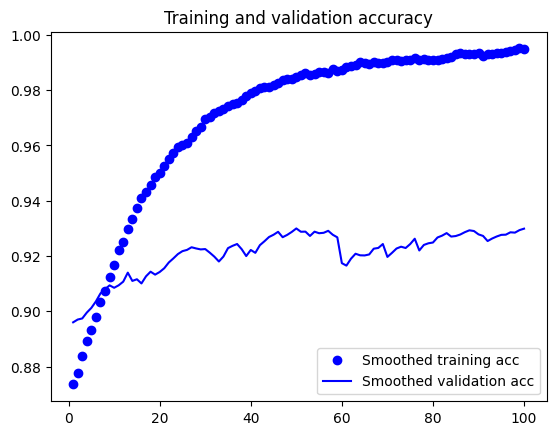

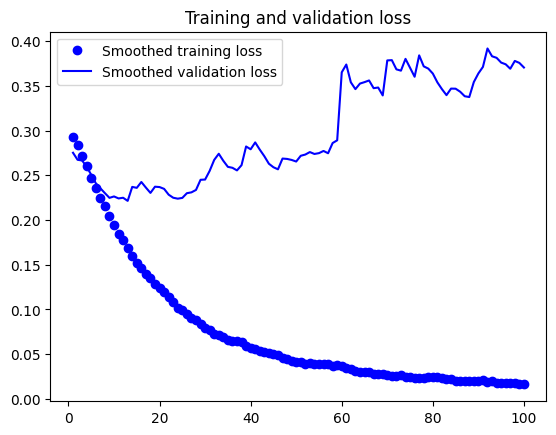

In [32]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - acc: 0.9445 - loss: 0.2699
test acc: 0.9430000185966492
